Code transferred over from Colab:
https://colab.research.google.com/drive/1nH1WuabNUx2wiX3UwHi_cYxwkJ78i12n?usp=sharing

In [1]:
# Import statements
import tensorflow as tf
# !pip install keras-tuner -q
# import keras_tuner # TODO: import this
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Plot formatting defaults
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('ytick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [ ]:
# Tensorboard stuff
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

from tensorboard.plugins.hparams import api as hp

In [4]:
# Load in data
mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

del mat

X_train, y_train = shuffle(W8_cell_data[:,1:], W8_cell_data[:,0]*100)
X_test = W9_cell_data[:,1:]
y_test = W9_cell_data[:,0]*100

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(80902, 2400)
(80902,)
(71081, 2400)


In [ ]:
def build_model(hp):

    # Set ranges for each layer of the MLP:
    layer_UB = [2400, 1200, 600, 300, 150]
    layer_LB = [1200, 600, 300, 100, 20]
    layer_step = [600, 300, 100, 100, 20]

    model = keras.Sequential()
    model.add(keras.Input(2400,))
    # Tune the number of layers.
    n_layers = hp.Int("num_layers", 1, 4)
    for i in range(n_layers):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Choice(f"units_{i}", [600, 1200, 2400]),
                activation="relu",
            )
        )
    # if hp.Boolean("dropout"):
    #     model.add(layers.Dropout(rate=0.25))
    model.add(
        layers.Dense(
                # Tune number of units separately.
                units=hp.Choice("units_3rd_to_last", [50, 100, 200]),
                activation="relu"
            )
    )
    model.add(
        layers.Dense(
                # Tune number of units separately.
                units=hp.Choice("units_2nd_to_last", [10, 20, 50]),
                activation="relu"
            )
    )
    model.add(layers.Dense(1, activation="linear"))
    # learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mean_squared_error",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="/tmp/tb",
    project_name="mlp",
)

tuner.search_space_summary()

In [ ]:
tuner.search(
    X_train[0:10000,:],
    y_train[0:10000],
    validation_split=0.2,
    batch_size=512,
    epochs=5,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

In [ ]:
# Get the top model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(X_test.shape[1],))
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
# Train model with optimal hyperparameters from above
def build_hp_model():

    model = keras.Sequential()
    model.add(keras.Input(2400,))
    model.add(layers.Dense(1200, activation="relu"))
    model.add(layers.Dense(1200, activation="relu"))
    model.add(layers.Dense(2400, activation="relu"))
    model.add(layers.Dense(200, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model

In [ ]:
hp_model = build_hp_model()
hp_model.summary()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [%]")
plt.show()

In [ ]:
history = hp_model.fit(X_train,
                    y_train,
                    epochs=5000,
                    verbose=2,
                    batch_size=4800,
                    validation_split=0.2)

hp_model.save("MLP_w8_5000")

In [2]:
hp_model = keras.models.load_model("mymodel_w8_5000")
# hp_model.evaluate(X_test, y_test, verbose=2)

2022-05-24 20:04:44.816161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-24 20:04:44.816265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-24 20:05:31.891082: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-24 20:05:31.952149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2222/2222 [==============================] - 7s 3ms/step


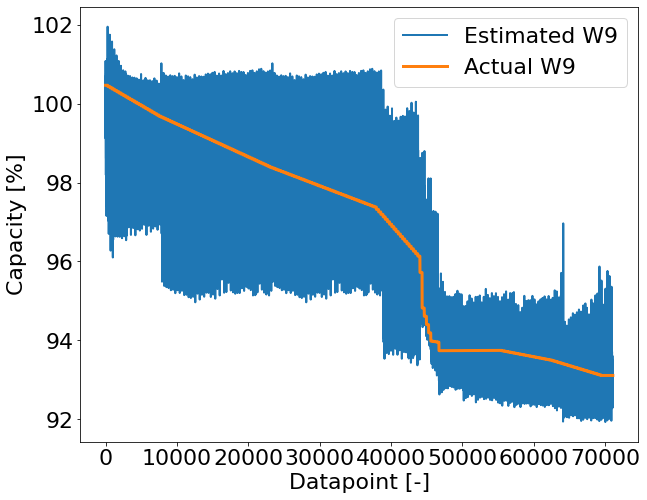

In [5]:
y_hat = hp_model.predict(X_test)
y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot)
plt.plot(y_test, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()

231/231 [==============================] - 1s 4ms/step


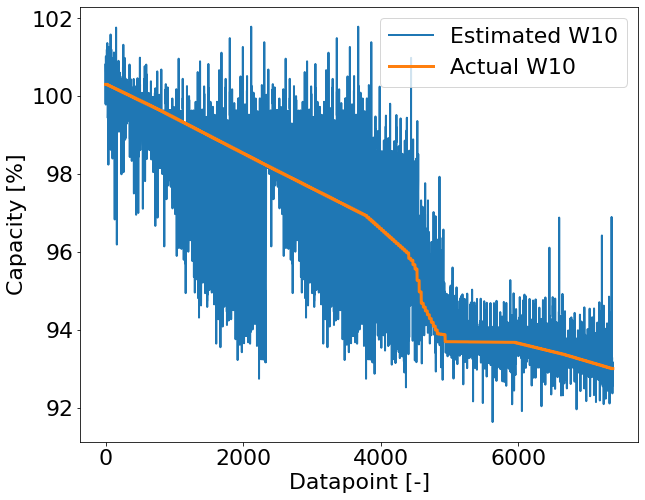

2022-05-24 20:06:32.809386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


231/231 - 1s - loss: 2.2023 - mean_squared_error: 2.2023 - 1s/epoch - 5ms/step


[2.202259063720703, 2.202259063720703]

In [8]:
# Validate on W10 cell

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

del mat

X_test_W10 = W10_cell_data[:,1:]
y_test_W10 = W10_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
# X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W10 = y_test_W10[0::10]
X_test_W10 = X_test_W10[0::10, :]

y_hat_W10 = hp_model.predict(X_test_W10)
y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_test_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
hp_model.evaluate(X_test_W10, y_test_W10, verbose=2)


268/268 [==============================] - 1s 3ms/step


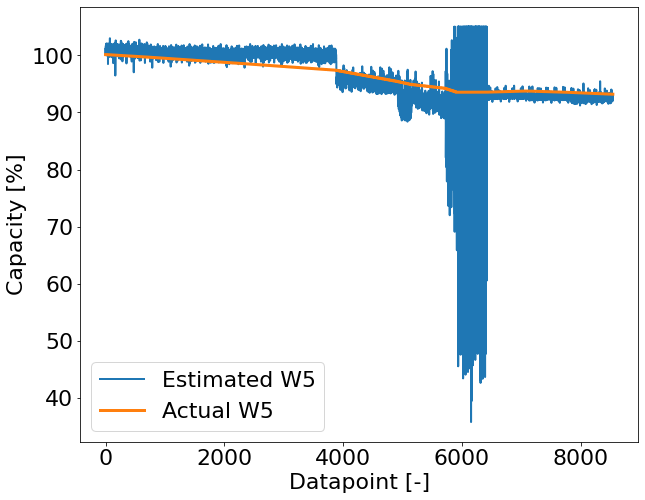

268/268 - 1s - loss: 6104.8931 - mean_squared_error: 6104.8931 - 895ms/epoch - 3ms/step


[6104.89306640625, 6104.89306640625]

In [10]:
# Validate on W5 cell

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

X_test_W5 = W5_cell_data[:,1:]
y_test_W5 = W5_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
# X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W5 = y_test_W5[0::10]
X_test_W5 = X_test_W5[0::10, :]

y_hat_W5 = hp_model.predict(X_test_W5)

y_hat_plot_w5_test = y_hat_W5
y_hat_plot_w5_test[y_hat_plot_w5_test>105] = 105

y_hat_plot_W5 = np.ravel(y_hat_W5)
plt.plot(y_hat_plot_W5)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
hp_model.evaluate(X_test_W5, y_test_W5, verbose=2)